 <b><h1>Truel problem</h1></b><br>
 <i>Original problem:</i> <br>
 <div style="margin-left: 30px">
 Three players are doing truel, where each can choose who to try to shoot, then next player plays and so on until only one winner is left. <br>
 If first player has 1/3 chance to hit, second has 2/3 and last has 100% chance to hit - what is chance of first player to win and who he should target at start ?<br>
 </div>
 <i>Generalized problem:</i><br>
 <div style="margin-left: 30px">
  N people are doing duel. Given their probabilities to hit, what are probability of each of them to win and who is initial target for each of them?<br>
</div>
<br>
<b>Python function that solves truel problem for arbitrary number of players, and finds not only winning chances for each player but also optimal target for each player.<br></b>
<ul>
    <li><i>exact solution:</i>  returns exact mathematical solution, not approximate simulation result</li>
    <li><i>fast:</i>  computes fast even with 4+ players </li>
    <li><i>find optimal targets:</i> can find optimal targets for each player, with options to allow intentional misses (default), selftargeting, or even random targeting </li>
    <li><i>fixed targets as parameter:</i>also allows specifying fixed targets for some or all players (for initial rounds while all are alive)</li>
</ul>

<br>
<h>Solution reasoning:</h><br>
<div style="margin-left: 30px">
     if we have N players, with probability of i-th player (0..N-1) in pHit[i], then if i-th player is on move and he is targeting T:<br>
        &nbsp;&nbsp;&nbsp;&nbsp;<b>pwin</b>(i first out of N)= <b>pHit</b>[i]* <b>pwin</b>(i+1 first out of N-1, T is removed ) + (1-<b>pHit</b>[i])* <b>pwin</b>(i+1 first, out of N)<br>
     Assuming we can get exact result for reduced number of players (N-1), we can express solution for N players with i-th player on move as function of solution for (i+1)th player on move:<br>
        &nbsp;&nbsp;&nbsp;&nbsp; <b>pwin</b>(i)= <b>v</b>[]+ k*<b>pwin</b>(i+1)  , where <b>v</b>[]= constant vector with N elements = pHit[i]*pwin(i+1 first out of N-1, T is removed )  , and k= 1-ph[i]  ... so we can express this as tuple pwn=(v[], k)  so that pwin(i)=pwn*pwin(i+1)<br>
    <br><i>Infinite loop:</i>
     <div style="margin-left: 30px">
        Recursivelly calling pwin(i+1) will eventually get to last player, who will have to rely on first player result callin pwin(0) - which would result in infinite loop<br>
        That infinite loop can be avoided by passing function that express result for win probabilities if initial player is on move as function of win probabilities if (i+1)th player is on move : pwin(0)=pw0=  f( pwin(i+1) ) =  pwn * pwin(i+1) , with pwn= (v[],k ) <br>
        That pw0 can be modified by each succesive player, and when we get to last player and he recalculate pw0, he will have pw0= f ( pwin(N+1) ) = f ( pwin(0) ) ... or pw0 = f(pw0 ) which can be solved directly, avoiding infinite loop<br>
        Given pwn=(v[],k) and pw0= pwn*pw0=  v[]+k*pw0 ->   pw0(1-k)= v[] ->  pw0[]= v[]/(1-k)  ... resulting in probability to win for each player, if first to play is initial player <br>
        That exact result for pw0 can be now returned back to exactly calculate pwin(N-1), pwin(N-2)... all way back to pwin(0) which will get same result as pw0.<br>
    </div>
     <i>Finding who to target:</i>
     <div style="margin-left: 30px">
        above calculation assume that each player knows in advance who is best target for him to shoot at (T).  If he does not know that, he need to apply same calculation to every possible target (including no target) and select one which give him best chance to win<br>
        when 'no target' is selected, his chance to win is slightly different formula:  pwin(i)= pwin(i+1)   - or if we want to present in same format as before ( pwin(i)= v[]+ k*pwin(i+1) ), then v[]=[0,0..0] and k=1, or in tuple for ([0,0...0], 1.0)<br>
       special case is if everyone decide to skip (no target), which would lead to infinite loop, so need to be forbidden in some way. For example - last player is not allowed to skip if everyone else did it.<br>
    </div>
</div>



<b>def truelC(pHit,o=[],c=-1,pw0=0, search=[-1], targets=[]):</b><br>
 Find probability to win, given order of remaining players in 'o' <br>
 
 <i>Starting parameters:</i><br>
 <div style="margin-left: 30px"> 
    pHit: probabilities of each starting player to hit. ph=[0.3,0.2,0.1,1] means there are 4 players initially<br>
    search: default=[-1]. What special targets are allowed when searching for best target. 0= self/suicide, -1= miss/ground,  -2= random (random will honor miss/suicide flags)<br>
    targets: default = all -10 (find best target). Array with target each player will choose at start (while all of them are alive). -10=find best target, -1=miss/ground, 0=target first player, 1=target 2nd player etc<br>
</div>
 <i>Intermediate/internal parameters:</i><br>
<div style="margin-left: 30px">     
    o: which players are still in game, and their order to shoot ( player indexes, zero based, from pHit. o=[2,0,3] means 3rd, 1st then 4th player with 2nd player out of game  )<br>
    c: circular countdown - reduced by one, when reach zero we would have to calling for initial player. For initial call with N players, c==N<br>
    pw0: how solution for win probabilities given initial player is on move depends on this win probabilities ( given o[0] player is on move ), for same number of players as in o[]<br>
</div>
<i>Result:</i> returns tuple (pw[], tw[] ):<br>
<div style="margin-left: 30px">     
        pw[]: probability of each player to win (given player shoot in 'o' order) <br>
        tw[]: who is their initial target (index in ph, if -1 it means they prefer to skip/miss )<br>
</div>    

In [104]:
import numpy as np 

# dictionary used for manual cache, since lru-cache does not work with arrays
pdict=dict()

# Find probability to win, given order of remaining players in 'o' 
def truelC(pHit,o=[],c=-1,pw0=0, search=[-1], targets=[]):
    # if order o[] is not supplied, this is very first call, with initial player probabilities in pHit - so create initial order and clear cache
    if len(o)==0:
        o= np.arange(len(pHit) , dtype=int) # they shoot initially in order [0,1,2,...]
        pdict.clear() # clear cache dictionary
    # check cache 
    key=o.tobytes()
    if key in pdict:
        return pdict[key]
    # array lengths and often used values
    no=len(pHit) # starting number of players - results always have this many elements regardles of len(o)
    n=len(o) # number of players remaining in game
    m=o[0] # m= index of player on move 
    phm= pHit[m] # probability of player on move to hit
    # if targets are not specified, set all to "find best", or -10.
    if len(targets)!=no: 
        targets=np.repeat(-10,no)
    # if last two parameters are not supplied this is "initial layer call", first call for this order of len(o) players, so set to defaults
    if c<0:
        c=n
        pw0= ( np.zeros(no), 1)
    # initial result
    bestPW=np.zeros(no)
    bestTW=np.zeros(no, dtype=int)

    # check edge cases with single player 
    if n<=1:
        # for n==0 leave all zero chances to win
        if n==1: 
            bestPW[m]=1 # for n==1 , only player has 100% chance to win, and will target noone
            bestTW[m]=-1
    else:
        # make new order where next player goes first
        o2=np.append(o[1:],o[0])

        # see if target was given or needs to be found
        trg = targets[m]
        if trg >-10:
            # if target was given, calc only for that target ( ignore miss/suicide/rnd limits, since this is given target )
            if trg>=0:
                i= np.where(o==trg)[0][0]
            else:
                i=trg
            validTargetIdx= np.array([i])
        else:
            #if target was not given as parameter for this player, include all standard targets 1..n-1 and special targets allowed in 'search' parameter (0=self,-1=miss,-2=random)
            validTargetIdx= np.concatenate( (np.array(search,dtype=int), np.arange(1,n)) )
        
        
        #### inner function that calculate coeficients (vs, ks, t ) for specific target index, using reduced number of players without that target ( target is given as index in 'o' ! )
        def coefsTarget(i):
            if i==-1:
                t=-1
                vs=np.zeros(no)
                ks=1
            else:
                t=o[i]
                # make reduced player list (without player 'i'), starting with next player ( so remove i-1 )
                o2r= np.delete(o2,i-1)
                # probabilities to win if o[0] hits o[i] - reduction to one less player.  Remove fixed targets, since those were valid only while all players were alive
                pwM,_=truelC(pHit,o=o2r,search=search,targets=[])
                # pwin(if targeting i )= p_hit*pwin(without i,n-1)+ (1-p_hit)*pwin(if next starts,n)
                vs=phm*pwM
                ks=1-phm
            return (vs,ks,t)


        #### inner function that calculate win probabilities (pw, tw, valid), given coeficients (vs,ks,t) and target t
        def oneTargetCoefs(coefs):
            vs,ks,t=coefs
            v0,k0=pw0
            pw0n=(v0+k0*vs, k0*ks)
            # calculate probability if missed and next player is on move
            if c>1:
                pwN, tw= truelC(pHit, o=o2, c=(c-1), pw0=pw0n,search=search, targets=targets) # recursive call
            else:
                # last player in circular list - he would rely on first player result (infinite loop if recursive call), but we use it to calculate exact 1st player chance as pwN
                # pw0= pw0n*pw0 = v0f+ k0f*pw0 ->  pw0(1-k0f)= v0f ->  pw0= v0f/(1-k0f)  ... and we store pwN= pw0
                v0f,k0f=pw0n
                if k0f<1 :
                    pwN= v0f/(1-k0f)
                else:
                    return (0,0,False)
                tw= np.zeros(no, dtype=int)
            # now finalize probabilities and targets for player o[0] if he targets player 't'
            pw=vs+ks*pwN
            tw[m]=t
            return (pw,tw,True)

        #### inner function that calculate win probabilities (pw, tw, valid) for specific target , given target index ( target is given as index in 'o' ! )
        def oneTarget(i):
            if i>=-1:
                # regular targets or -1 as miss
                coefs=coefsTarget(i)
            elif i==-2:
                # random target, any allowed target except again random
                vs=np.zeros(no)
                nt=0
                for u in validTargetIdx:
                    if u!=-2:
                        cf=coefsTarget(u)
                        vs+=cf[0]
                        nt+=1
                if nt>0:
                    vs/=nt
                # composite coeficient if all valid targets have equal random chance
                coefs= (vs, 1-phm, -2)
            # calculate win probabilities based on coefs
            return oneTargetCoefs(coefs)


        # check each allowed target, and find best one
        for i in validTargetIdx:
            pw,tw,valid= oneTarget(i)
            if valid and (pw[m]>=bestPW[m]):
                bestPW=pw
                bestTW=tw
    # store in cache (only for initial layer call) and return result
    res=(bestPW, bestTW)
    if c==n:
        pdict[key]=res
    return res


Procedure to invoke truelC calculation and pretty print result. <br>
It accept same starting parameters as truelC, and return same result:<br>
 <i>Starting parameters:</i><br>
 <div style="margin-left: 30px"> 
    pHit: probabilities of each starting player to hit. ph=[0.3,0.2,0.1,1] means there are 4 players initially<br>
    search: default=[-1]. What special targets are allowed when searching for best target. 0= self/suicide, -1= miss/ground,  -2= random (random will honor miss/suicide flags)<br>
    targets: default = all -10 (find best target). Array with target each player will choose at start (while all of them are alive). -10=find best target, -1=miss/ground, 0=target first player, 1=target 2nd player etc<br>
</div>
 <i>Intermediate/internal parameters:</i><br>
<div style="margin-left: 30px">     
    o: which players are still in game, and their order to shoot ( player indexes, zero based, from pHit. o=[2,0,3] means 3rd, 1st then 4th player with 2nd player out of game  )<br>
    c: circular countdown - reduced by one, when reach zero we would have to calling for initial player. For initial call with N players, c==N<br>
    pw0: how solution for win probabilities given initial player is on move depends on this win probabilities ( given o[0] player is on move ), for same number of players as in o[]<br>
</div>
<i>Result:</i> returns tuple (pw[], tw[] ):<br>
<div style="margin-left: 30px">     
        pw[]: probability of each player to win (given player shoot in 'o' order) <br>
        tw[]: who is their initial target (index in ph, if -1 it means they prefer to skip/miss )<br>
</div>    
Printed result shows :  pHit%= [,,..] pWin%= [,,..] targets= [,,..] tm= h:mm:ss.ms &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ; win probabilities are rounded to one decimal, and targets are final/optimal targets for each player (tw[]) zero based. Asterix (*) denote that target was forced as parameter.<br>

In [112]:
import datetime
# Time and print truel result
# find probability for each player to win truel, given chances to hit - if they shoot in order with [0] first
def truel(pHits, search=[-1], targets=[], decimals=1):
    ph=np.array(pHits, dtype=float)
    t0=datetime.datetime.now()
    r=truelC(ph, search=search, targets=targets) # call recursive solution
    if len(targets)==0:
        ts=str(r[1])
    else:
        ts=""
        for i in range(len(targets)):
            if (targets[i]<=-10):
                ts=ts+", "+str(r[1][i])
            else:
                ts=ts+", *"+str(targets[i])
        ts="["+ts[1:]+" ]"
    if decimals>0:
        print(" pHit%=",np.around(ph*100,decimals),"pWin%=",np.around(r[0]*100,decimals),"targets=",ts,"tm=",datetime.datetime.now()-t0)
    return r

<br>Solution to original problem, where first player can hit in 1/3 cases, second player in 2/3 cases and last player always hit - and program is allowed to find optimal targets for each player:<br>
<div style="margin-left: 30px">   
    <ul>
    <li>best for first player is to <b>intentionnally miss</b> ( -1 as first value in targets )</li>
    <li>his probability to win is 39.7% ( first value in pWin%[] ) ... in fact, first player has highest win probability of all 3 players</li>
    <li>best target for other two players are each other ( second player shoot third and vice-versa )</li>
    </ul>
</div>

In [113]:
truel([1/3,2/3,1]);

 pHit%= [ 33.3  66.7 100. ] pWin%= [39.7 38.1 22.2] targets= [-1  2  1] tm= 0:00:00.001994


<br><br>Example that demonstrate how truel() can find optimal solution for generalized problem with N players - here with 4 players, each 25% better shot than previous.<br>
<div style="margin-left: 30px">   
    <ul>
    <li>best for first player is to shoot last player, and he has 22.2% chance to win</li>
    <li>best for second player is to shoot first player, and he has 41.8% chance to win - most of all players</li>
    <li>best for third player is to shoot last player, and he has 27.8% chance to win</li>
    <li>best for last player is to shoot third player, and he has only 8.2% chance to win - least of all players, even if he is best shot</li>
    </ul>
</div>

In [114]:
truel([1/4,1/2,3/4,1]);

 pHit%= [ 25.  50.  75. 100.] pWin%= [22.2 41.8 27.8  8.2] targets= [3 0 3 2] tm= 0:00:00.013976


<br>Same example as above, but we force all to shoot at highest shot, allowing only first player to find optimal target (-10).<br>
Now first player is better ( at 34% chance to win ) but second player is worse and now best chance to win has thord player with 38%.

In [115]:
truel([1/4,1/2,3/4,1],targets=[-10,3,3,2]);

 pHit%= [ 25.  50.  75. 100.] pWin%= [34.2 24.2 38.   3.5] targets= [ 3, *3, *3, *2 ] tm= 0:00:00.005618



<h1><br>Investigate for three players: A, B and C</h1><br>
where their chances to hit are 0 < = pA < = pB < = pC , and pC==1 . In other words, first player to shoot (A) has lowest chance to hit, and last player (C) always hit. <br>

Plot will show pA on Y-axis (0% at bottom .. 100% at top ) and pB on X-axis (0% left .. 100% right ), while pC is constant at 100%<br>
Colors are ligher for higher chance to win, and darker for lower chance to win, and RGB color determine person who has highest chance to win:<br>
<ul style="margin-left: 30px"> 
    <li><font color=red>Red</font>:   player A has highest chance to win</li>
    <li><font color=green>Green</font>: player B has highest chance to win</li>
    <li><font color=blue>Blue</font>:  player C has highest chance to win</li>
</ul>
Procedure testAB1() support different scenarions based on what targets are allowed to players while all 3 are alive:  fixed on most dangerous, fixed on specific player, miss, suicide, optimal target etc...<br>




In [153]:
import numpy as np
import time
from matplotlib import pyplot as plt

show=True

def testAB1(search=[-1], targets=[], AgtB=False):
    size = 100
    gimage = np.zeros((size, size,3), dtype = np.float32)
    tot=0
    def oneSpot(a,b):
        pHits=np.array([a/size,b/size,1])
        r= truelC(pHits, search=search, targets=targets)
        # find who wins, and his chance
        w= np.argmax(r[0])
        pw= r[0][w]
        score[w]+=1
        nonlocal tot
        tot+=1
        gimage[a,b,w]=max(pw,0)
        
    score=np.zeros(3)
    t0= time.perf_counter_ns()
    # bottom right half - when pA <= pB
    for b in range(size):
        for a in range(b+1):
            oneSpot(a,b)
    # upper left half - when pA >= pB
    for a in range(1,size):
        for b in range(a):
            if AgtB:
                oneSpot(a,b)
            else:
                gimage[a,b,:]=1.0
    tm= (time.perf_counter_ns()-t0)//1000000
    score=np.around(score*(100/tot),decimals=1)
    print(f"Test completed in {tm} ms. Scores ( how often player has best chance to win ) :  A= {score[0]}%, B= {score[1]}%, C= {score[2]}%" )
    plt.gca().invert_yaxis()    
    plt.imshow(gimage,origin='lower')
    plt.show()

<br>When all players are shooting at higherst threat - so A and B target C, anc C target B :<br>
We see that player A can win in very small number of cases ( 4.7%, red color is dominant only in small area around pA ~ 40% and pB ~ 40% )

Test completed in 2207 ms. Scores ( how often player has best chance to win ) :  A= 4.7%, B= 77.7%, C= 17.6%


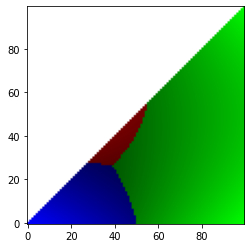

In [156]:
testAB1(targets=[2,2,1])

<br>When B and C are shooting at higherst threat (each other) and A intentionally miss ( his target is -1 ) :<br>
Here player A can win in much more cases - in fact, red area is largest at 41.1%, meaning he wins more than B or C.

Test completed in 1878 ms. Scores ( how often player has best chance to win ) :  A= 41.1%, B= 35.3%, C= 23.6%


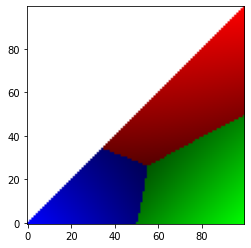

In [157]:
testAB1(targets=[-1,2,1])

<br>When B and C are shooting at higherst threat (each other) and A chooses optimal target ( his target is -10, which means "find best target" ) :<br>
This does not improve much, just by 0.3% - obviously shooting to miss was optimal tactic for A in most cases anyway. Only place it improves is small additional red area around pA ~ 30% and pB ~30%

Test completed in 3173 ms. Scores ( how often player has best chance to win ) :  A= 41.4%, B= 35.3%, C= 23.3%


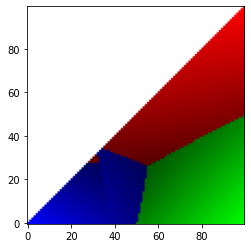

In [158]:
testAB1(targets=[-10,2,1])

To demonstrate that small improvement, here is calculation at pA=pB=30%, when A must miss (then C has highest chance to win, not A) and when A can choose optimal target ( targeting C, and A has highest chance to win)

In [159]:
truel([0.3,0.3,1],targets=[-1,2,1])
truel([0.3,0.3,1],targets=[-10,2,1]);

 pHit%= [ 30.  30. 100.] pWin%= [38.6 12.4 49. ] targets= [ *-1, *2, *1 ] tm= 0:00:00.001036
 pHit%= [ 30.  30. 100.] pWin%= [39.4 26.3 34.3] targets= [ 2, *2, *1 ] tm= 0:00:00.000997


<br>When all players are allowed to select optimal target :<br>
This is exactly same as when only A was allowed to select optimal target, indicating that for B and C it is always optimal to shoot each other.

Test completed in 6636 ms. Scores ( how often player has best chance to win ) :  A= 41.4%, B= 35.3%, C= 23.3%


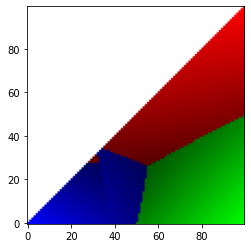

In [160]:
testAB1()

<br><h1>But what if we look at entire area, including cases when pA > pB ? </h1><br>
Will "B and C target each other and A always miss" still be similar to "all players choosing optimal target" ? <br>
<br>
This is case when "B and C target each other and A always miss" :  player A wins in vast majority of cases (61.7%) - because others ignore him even when pA>pB <br>

Test completed in 3684 ms. Scores ( how often player has best chance to win ) :  A= 61.7%, B= 17.8%, C= 20.5%


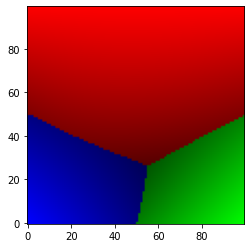

In [162]:
testAB1(targets=[-1,2,1], AgtB=True)

<br>This is case when "all players choosing optimal target" :  player A now wins much less (38.9%), almost tied with B (36.7%) - since now all choose optimal target, and thus B and C fare bit better<br>
Another effect is that area is not so uniformly separated - now there are patches where different players have highest chance to win.

Test completed in 12853 ms. Scores ( how often player has best chance to win ) :  A= 38.9%, B= 36.7%, C= 24.4%


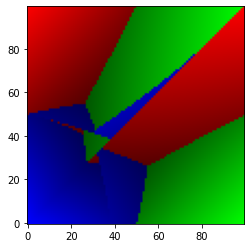

In [154]:
testAB1(AgtB=True)